In [2]:
"""
스타일 변환 (style Transfer)은 두 장의 서로 다른 이미지를 사용하여 
새로운 이미지를 합성하는 방법이다 - 스타일 전이라고도 부른다
합성곱 신경망(CNN)을 통해 각 레이어에서 추출되는 다양한 특징을 이용한다

처음에 입력으로 주어지는 두 장의 이미지 중에서 하나는 콘텐츠(Contents) 이미지로써
이미지의 구조와 형태를 나타내는 콘텐츠를 추출한다 
다른 이미지는 스타일(Style) 이미지로써 이미지 고유의 스타일만을 추출한다

사전 학습된 모델을 활용해 스타일 변환을 구현한다. 처음부터 모델을 학습하려면 
많은 그림 데이터와 오랜 학습이 필요하기 때문이다
"""
import os 
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from PIL import Image


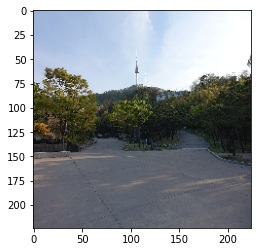

In [3]:
contents = cv2.imread("contents.jfif")
contents = cv2.resize(contents,(224, 224))
plt.imshow(cv2.cvtColor(contents, cv2.COLOR_BGR2RGB))

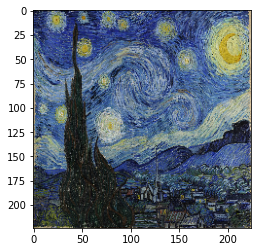

In [6]:
"""
스타일을 추출할 고흐 그림 파일을 이용
"""
style = cv2.imread("style.jpg")
style = cv2.resize(style,(224, 224))
plt.imshow(cv2.cvtColor(style, cv2.COLOR_BGR2RGB))

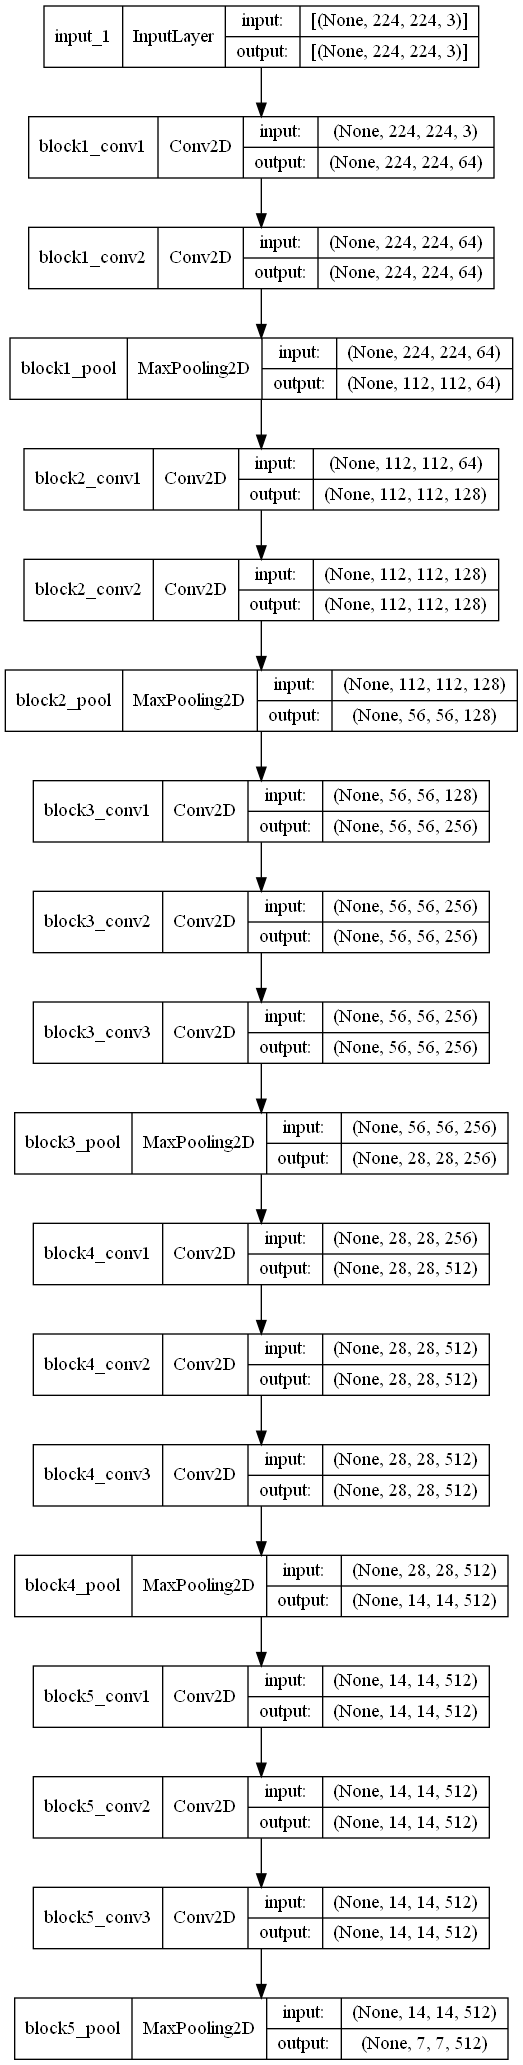

In [7]:
"""
사전 학습 모델로 VGG16을 사용한다 
"""
vgg_model = tf.keras.applications.VGG16(input_shape = (224, 224, 3),
                                       include_top = False, weights="imagenet")

vgg_model.trainable=False
tf.keras.utils.plot_model(vgg_model, show_shapes=True)

In [8]:
"""
스타일 변환 예제에서 사용하는 손실함수를 다음과 같이 구성
Contents Loss 와 Style Loss 로 나눈다
Contents Loss 는 변환할 입력 이미지를 사전 학습 모델에 넣었을 때 중간 층에서 나온 출력 값과,
콘텐츠 이미지를 모델에 넣었을 때 같은 층의 출력 값 사이의 오차(MSE)로 구한다

Style Loss 는 변환할 입력 이미지를 모델에 넣었을 때 4개의 중간 층에서 출력 값으로 
Gram Matrix를 구하고, 스타일 이미지를 모델에 입력했을 때 이들 4개층의 출력 값들의 
Gram Matrix를 계산한 뒤에 이들의 차이가 된다
Gram Matrix는 채널별 공분산을 구하는 형태이다

Contents Loss 는 "block3_conv3"에서 구하고 
Style Loss 는 block1_conv2 block2_conv2, block3_conv3, block4_conv3 에서 구하려고 한다
"""


style_transfer_model=tf.keras.Model(inputs=[vgg_model.input],
                                    outputs=[
                                            vgg_model.get_layer(name='block1_conv2').output,
                                            vgg_model.get_layer(name='block2_conv2').output,
                                            vgg_model.get_layer(name='block3_conv3').output,
                                            vgg_model.get_layer(name='block4_conv3').output
])

style_transfer_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
"""
Style Loss의 Ground True 값을 미리 구하고, 출력 값의 형태를 확인한다
"""
style_true_b1c1, style_true_b2c2, style_true_b3c3, style_true_b4c3 = style_transfer_model.predict(np.reshape(style,(-1,224,224,3)))

style_true_b1c1.shape

(1, 224, 224, 64)

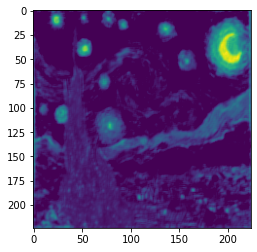

In [11]:
"""
추출된 스타일 특성맵(피처맵)을 시각화 한다
"""
plt.imshow(style_true_b1c1[0][:,:,60])

In [13]:
"""
Content Loss의 Ground True 값을 구한다
"""
contents_true_b1c1, contents_true_b2c2, contents_true_b3c3, contents_true_b4c3 = style_transfer_model.predict(np.reshape(contents,(-1,224,224,3)))

contents_true_b3c3.shape

(1, 56, 56, 256)

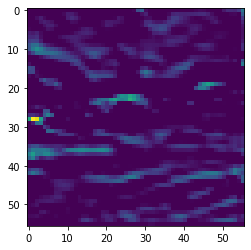

In [15]:
"""
추출된 콘텐츠 특성맵을 시각화
"""
plt.imshow(contents_true_b3c3[0][:, :, 250])

In [16]:
"""
Gram Matrix 함수를 정의한다
"""
def gram_matrix(x):
    reshape_x=tf.transpose(x,[2,1,0])
    s = tf.shape(reshape_x)
    reshape_x=tf.reshape(reshape_x,(s[0],s[1]*s[2]))
    reshape_x_t=tf.transpose(reshape_x)
    dot=tf.matmul(reshape_x,reshape_x_t)
    dot=tf.cast(dot,dtype='float32')
    dot=dot/tf.cast(tf.shape(reshape_x)[0], tf.float32)/tf.cast(tf.shape(reshape_x)[1], tf.float32)
    return dot

gram_matrix(contents_true_b3c3[0])


<tf.Tensor: shape=(256, 256), dtype=float32, numpy=
array([[671.06805  , 300.29062  ,  29.795645 , ...,  79.8843   ,
         32.292248 ,  33.502625 ],
       [300.29062  , 677.1281   ,  38.146957 , ...,  76.13207  ,
         61.753227 ,  23.60127  ],
       [ 29.795645 ,  38.146957 ,  61.71986  , ...,  18.556124 ,
          0.720388 ,   0.7690808],
       ...,
       [ 79.8843   ,  76.13207  ,  18.556124 , ..., 184.6969   ,
         18.261183 ,   1.3966694],
       [ 32.292248 ,  61.753227 ,   0.720388 , ...,  18.261183 ,
         94.52861  ,   5.901966 ],
       [ 33.502625 ,  23.60127  ,   0.7690808, ...,   1.3966694,
          5.901966 ,  25.228296 ]], dtype=float32)>

In [18]:
"""
스타일 변환을 적용할 남산타워 이미지를 입력값으로 지정한다
"""
# 스타일 변환을 적용할 남산타워 이미지 
input_image = cv2.imread('contents.jfif')   # 책에 오타 jpg로 써있네
input_image = cv2.resize(input_image, (224, 224))



1
s_loss tf.Tensor(1016696.94, shape=(), dtype=float32)
c_loss_3 tf.Tensor(0.0, shape=(), dtype=float32)

2
s_loss tf.Tensor(398311.2, shape=(), dtype=float32)
c_loss_3 tf.Tensor(79563.67, shape=(), dtype=float32)

3
s_loss tf.Tensor(279097.6, shape=(), dtype=float32)
c_loss_3 tf.Tensor(144613.36, shape=(), dtype=float32)

4
s_loss tf.Tensor(286953.34, shape=(), dtype=float32)
c_loss_3 tf.Tensor(109482.07, shape=(), dtype=float32)

5
s_loss tf.Tensor(211615.78, shape=(), dtype=float32)
c_loss_3 tf.Tensor(155191.27, shape=(), dtype=float32)

6
s_loss tf.Tensor(230217.73, shape=(), dtype=float32)
c_loss_3 tf.Tensor(122279.266, shape=(), dtype=float32)

7
s_loss tf.Tensor(184613.86, shape=(), dtype=float32)
c_loss_3 tf.Tensor(168853.61, shape=(), dtype=float32)

8
s_loss tf.Tensor(196210.8, shape=(), dtype=float32)
c_loss_3 tf.Tensor(126141.31, shape=(), dtype=float32)

9
s_loss tf.Tensor(143642.33, shape=(), dtype=float32)
c_loss_3 tf.Tensor(163789.36, shape=(), dtype=float32)

10
s_los


78
s_loss tf.Tensor(33871.0, shape=(), dtype=float32)
c_loss_3 tf.Tensor(170055.2, shape=(), dtype=float32)

79
s_loss tf.Tensor(171695.5, shape=(), dtype=float32)
c_loss_3 tf.Tensor(232574.92, shape=(), dtype=float32)

80
s_loss tf.Tensor(33612.793, shape=(), dtype=float32)
c_loss_3 tf.Tensor(170089.78, shape=(), dtype=float32)

81
s_loss tf.Tensor(172439.67, shape=(), dtype=float32)
c_loss_3 tf.Tensor(235797.02, shape=(), dtype=float32)

82
s_loss tf.Tensor(32727.4, shape=(), dtype=float32)
c_loss_3 tf.Tensor(169526.53, shape=(), dtype=float32)

83
s_loss tf.Tensor(174743.22, shape=(), dtype=float32)
c_loss_3 tf.Tensor(238739.31, shape=(), dtype=float32)

84
s_loss tf.Tensor(31468.836, shape=(), dtype=float32)
c_loss_3 tf.Tensor(170651.42, shape=(), dtype=float32)

85
s_loss tf.Tensor(176889.95, shape=(), dtype=float32)
c_loss_3 tf.Tensor(240815.55, shape=(), dtype=float32)

86
s_loss tf.Tensor(44357.78, shape=(), dtype=float32)
c_loss_3 tf.Tensor(166867.22, shape=(), dtype=float32)

s_loss tf.Tensor(355970.5, shape=(), dtype=float32)
c_loss_3 tf.Tensor(280980.75, shape=(), dtype=float32)

155
s_loss tf.Tensor(35379.652, shape=(), dtype=float32)
c_loss_3 tf.Tensor(197791.94, shape=(), dtype=float32)

156
s_loss tf.Tensor(396879.7, shape=(), dtype=float32)
c_loss_3 tf.Tensor(287033.16, shape=(), dtype=float32)

157
s_loss tf.Tensor(37821.027, shape=(), dtype=float32)
c_loss_3 tf.Tensor(195241.86, shape=(), dtype=float32)

158
s_loss tf.Tensor(476476.53, shape=(), dtype=float32)
c_loss_3 tf.Tensor(293983.6, shape=(), dtype=float32)

159
s_loss tf.Tensor(26100.502, shape=(), dtype=float32)
c_loss_3 tf.Tensor(200774.8, shape=(), dtype=float32)

160
s_loss tf.Tensor(546973.06, shape=(), dtype=float32)
c_loss_3 tf.Tensor(302018.16, shape=(), dtype=float32)

161
s_loss tf.Tensor(18659.86, shape=(), dtype=float32)
c_loss_3 tf.Tensor(203622.78, shape=(), dtype=float32)

162
s_loss tf.Tensor(589578.56, shape=(), dtype=float32)
c_loss_3 tf.Tensor(312160.22, shape=(), dtype=fl

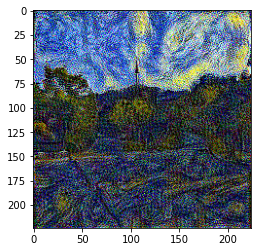

In [19]:
"""
옵티마이저를 Adam으로 사용하고 스타일 변환 모델을 학습한다
주의할 점은 입력 이미지로 콘텐츠 이미지를 사용하지만, 
반드시 텐서로 변환해야한다
이렇게 하면 Gradient 값을 구해 입력 이미지를 변경하여
새로운 스타일로 변환할 수 있다
"""
img_avi=np.zeros((224,224,3))
opt=tf.keras.optimizers.Adam(10.0)

fcc=cv2.VideoWriter_fourcc(*'DIVX')
out=cv2.VideoWriter('style_transfer.avi',fcc,10.0,(224,224))

for epoch in range(200):
    input_image=tf.reshape(input_image,(-1,224,224,3))
    input_image=tf.cast(input_image,dtype='float32')
    input_image = tf.Variable(input_image, dtype=tf.float32)
    with tf.GradientTape() as tape:
        
        b1c1,b2c2,b3c3,b4c3=style_transfer_model(input_image)
        
        s_loss_1=tf.stop_gradient(gram_matrix(style_true_b1c1[0]))-gram_matrix(b1c1[0])
        s_loss_1=tf.reduce_mean(tf.square(s_loss_1))
        s_loss_2=tf.stop_gradient(gram_matrix(style_true_b2c2[0]))-gram_matrix(b2c2[0])
        s_loss_2=tf.reduce_mean(s_loss_2*s_loss_2)
        s_loss_3=tf.stop_gradient(gram_matrix(style_true_b3c3[0]))-gram_matrix(b3c3[0])
        s_loss_3=tf.reduce_mean(s_loss_3*s_loss_3)
        s_loss_4=tf.stop_gradient(gram_matrix(style_true_b4c3[0]))-gram_matrix(b4c3[0])
        s_loss_4=tf.reduce_mean(s_loss_4*s_loss_4)
              
        c_loss_1=contents_true_b1c1-b1c1
        c_loss_1=tf.reduce_mean(tf.square(c_loss_1))
        c_loss_2=contents_true_b2c2-b2c2
        c_loss_2=tf.reduce_mean(tf.square(c_loss_2))
        c_loss_3=contents_true_b3c3-b3c3
        c_loss_3=tf.reduce_mean(tf.square(c_loss_3))
        c_loss_4=contents_true_b4c3-b4c3
        c_loss_4=tf.reduce_mean(tf.square(c_loss_4))

        s_loss=(s_loss_1+s_loss_2+s_loss_3+s_loss_4)
        c_loss=(c_loss_1+c_loss_2+c_loss_3+c_loss_4)/4.
        loss=s_loss*10.0+c_loss_3
    grad=tape.gradient(loss,input_image)
    opt.apply_gradients([(grad,input_image)])
    input_image=tf.cast(input_image,dtype=tf.int32)
    input_image=tf.clip_by_value(input_image,0,255)
    img_avi=input_image.numpy()[0]
    if((epoch+0)%10==0):
        cv2.imwrite('{}.jpg'.format(epoch), img_avi)
    out.write(np.uint8(img_avi))
    print()
    print(epoch+1)
    print('s_loss',s_loss)
    print('c_loss_3',c_loss_3)
plt.imshow(input_image[0][:,:,::-1])
out.release()
cv2.destroyAllWindows()